# Capstone Project - The Battle of Dutch Cities
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The purpose of this research is to compare all **provincial capitals** of the **Netherlands** on the basis of **facilities and venues**. Note how a few big Dutch cities aren't capitals within it's provice, so Rotterdam and Amsterdam will be included within the data sample as well. The analysis will be specifically based on the **relative frequencies** of venues per city inhabitant.

Dutch inhabitants often have conceptions about how for example Amsterdam has a large number of trendy coffee bars. How does this hold for our **Northern cities** if you correct for the number of inhabitants? 

Using this analysis, several insights can be obtained. We will try to cluster cities based on the relative venue frequencies. As such, one can find comparable cities within a given radius. This can be used for various purposes, including population research, marketing and business propositions.  

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our classification are:
* List of capital cities per province
* Number of inhabitants in the city
* Venues in (capital) city
* Exact city location (GPS coordinates)

Following data sources will be needed to extract/generate the required information:
* List of capital cities per province can be obtained from the **Provinces of the Netherlands Wikipedia page**
* Number of city inhabitants will be extracted from each cities' **Wikipedia page**
* Venues in (capital) city, their type and location will be obtained using **Foursquare API**
* Exact city location (GPS coordinates) will be obtained using **Geopy package**

### Capital Cities

To retrieve the Dutch province capitals and its inhabitants, we use a Wikipedia page and extract the data:

In [2]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [3]:
url = "https://nl.wikipedia.org/wiki/Provincies_van_Nederland"

In [4]:
page = urllib.request.urlopen(url)

In [5]:
soup = BeautifulSoup(page)

In [6]:
all_tables=soup.find_all('table')

In [7]:
right_table=soup.find('table', class_='wikitable sortable')
print (right_table)

<table class="wikitable sortable">
<tbody><tr>
<th class="unsortable"><a href="/wiki/Vlag" title="Vlag">Vlag</a>
</th>
<th><a href="/wiki/Provincie" title="Provincie">Provincie</a>
</th>
<th><a href="/wiki/Bevolking" title="Bevolking">Bevolking</a><sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th><a href="/wiki/Oppervlakte" title="Oppervlakte">Oppervlakte</a><br/>(land+water) in km²
</th>
<th>Oppervlakte<br/>(land) in km²
</th>
<th><a href="/wiki/Bevolkingsdichtheid" title="Bevolkingsdichtheid">inw./km²</a><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>
</th>
<th><a href="/wiki/Hoofdstad" title="Hoofdstad">Hoofdstad</a>
</th>
<th>Gemeente met de<br/>meeste inwoners
</th></tr>
<tr>
<td><a class="image" href="/wiki/Bestand:Flag_Groningen.svg"><img alt="Flag Groningen.svg" data-file-height="500" data-file-width="750" decoding="async" height="21" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/01/Flag_Groningen.svg/32px-

In [8]:
#Generate lists
A=[]
B=[]
links=[]
for row in right_table.findAll("tr"):
    cells = row.findAll('td')
    if len(cells)==8:
        A.append(cells[6].find(text=True))
        
        links =(cells[6].find("a"))
        B.append(links.get('href'))      

In [9]:
A.append("Amsterdam")
A.append("Rotterdam")
B.append("/wiki/Amsterdam")
B.append("/wiki/Rotterdam")

In [10]:
def getInhabitants(B):
    urls=[]
    inhabitants=[]
    for element in B:
        defaulturl = "https://nl.wikipedia.org"
        cityurl = defaulturl + element
        urls.append(cityurl)
    for url in urls:
        url2 = url
        page2 = urllib.request.urlopen(url2)
        soup2 = BeautifulSoup(page2)
        table2=soup2.find('table', class_='toccolours')
        tags=table2.find_all("td")
        for tag in tags:
            if 'Inwoners' in tag.text:
                thisrow = tag.parent
                thistd = thisrow.find_all("td")
                for td in thistd:
                    if not 'Inwoners' in td.text:
                        inhabitants1 = td.text
                        inhabitants2 = inhabitants1.split(" ", 1)
                        inhabitants3 = inhabitants2[0].strip(".?/\n")
                        inhabitants3 = inhabitants3.replace('[1]', '')
                        inhabitants3 = inhabitants3.replace('.', '')
                        if inhabitants3[1].isdigit():
                            inhabitants.append((format(int(inhabitants3), ',')))

    return(inhabitants)

In [11]:
df=pd.DataFrame(A,columns=['City'])
df['Inhabitants']=getInhabitants(B)

In [12]:
df

,City,Inhabitants
0,Groningen,"231,618"
1,Leeuwarden,"92,235"
2,Assen,"67,970"
3,Zwolle,"127,492"
4,Lelystad,"77,872"
5,Arnhem,"159,277"
6,Utrecht,"352,795"
7,Haarlem,"161,213"
8,Den Haag,"537,988"
9,Middelburg,"41,640"


## Methodology <a name="methodology"></a>

The analysis will be done by retrieving venues for each of the cities and getting all the venue categories. The number of venue per category per city will be divided by the cities inhabitants divided by 1,000. Thus, our result will show the relevant frequency of each venue per 1,000 inhabitants. This will allow for easier comparison.

Next, using Scikit Learn, we will use the Kmeans clustering algorithm to determine the optimal number of clusters and run the analysis. Finally these clusters will be marked on a map of the Netherlands, showing how cities compare.

## Analysis <a name="analysis"></a>

To start the analysis, first we have to import several libraries. We will need Scikit Learn for the K-means clustering and determining the optimal K. Geopy will be used to find coordinates of our cities. Folium for creating the map and matplotlib for adding markers to the map.

In [186]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Let's initiate new series to add each city's longitude and latitude to.

In [214]:
LA=[]
LO=[]
CT=[]
for city in df.iloc[:,0]:
    address = city
    geolocator = Nominatim(user_agent="tr_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    CT.append(city)
    LA.append(latitude)
    LO.append(longitude)

In [15]:
df['Latitude']=LA
df['Longitude']=LO
cities = df
cities

,City,Inhabitants,Latitude,Longitude
0,Groningen,"231,618",53.221792,6.558245
1,Leeuwarden,"92,235",53.199685,5.800691
2,Assen,"67,970",52.990372,6.553378
3,Zwolle,"127,492",52.514565,6.097720
4,Lelystad,"77,872",52.515095,5.476891
5,Arnhem,"159,277",52.005664,5.876235
6,Utrecht,"352,795",52.080986,5.127684
7,Haarlem,"161,213",52.383706,4.643560
8,Den Haag,"537,988",52.074946,4.269680
9,Middelburg,"41,640",51.505295,3.610071


Initiate the keys for the Foursquare API

In [16]:
CLIENT_ID = 'SLZFMIATKLQ4PJUHYMT1N44QLCPJGY3N1ZH5EEGYIGWSQKPM' # your Foursquare ID
CLIENT_SECRET = 'ETYWLEGIIDTQRIEF0RMINOAXR00UIS1T22EMFZWLIEDFQF3K' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Define a function to get the venues nearby in each city center. The top 150 venues in a radius of 5,000 meters from the city center will be retrieved.

In [161]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=150):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [215]:
Venues = getNearbyVenues(names=cities['City'],
                                   latitudes=cities['Latitude'],
                                   longitudes=cities['Longitude']
                                  )


Groningen
Leeuwarden
Assen
Zwolle
Lelystad
Arnhem
Utrecht
Haarlem
Den Haag
Middelburg
's-Hertogenbosch
Maastricht
Amsterdam
Rotterdam


In [163]:
print(Venues.shape)
Venues.head()
Venues.groupby('City').count()
print('There are {} uniques categories.'.format(len(Venues['Venue Category'].unique())))

(1254, 7)
There are 210 uniques categories.


Use encoding to get the venues category and use a binary method to show if it's present in the city or not (per venue).

In [164]:
# one hot encoding
Venues_onehot = pd.get_dummies(Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Venues_onehot['City'] = Venues['City'] 

# move neighborhood column to the first column
fixed_columns = [Venues_onehot.columns[-1]] + list(Venues_onehot.columns[:-1])
Venues_onehot = Venues_onehot[fixed_columns]

Generating a specific Dataframe with the relative number of venues per inhabitant, this is multiplied by a 1000 for easier interpretation

In [165]:
Venues_grouped = Venues_onehot.groupby('City').sum().reset_index()
Venues_relative = Venues_grouped
Venues_relative_freq = Venues_relative
Venues_relative["inhabitants"] = cities.iloc[:,1:2]
Venues_relative['inhabitants'] = Venues_relative['inhabitants'].str.replace(',', '')
Venues_relative.inhabitants = Venues_relative.inhabitants.astype(int)
Venues_relative.iloc[:, 1:-1] = Venues_relative.iloc[:, 1:-1].astype(int)

Venues_relative_freq = Venues_relative
Venues_relative_freq = Venues_relative.iloc[:,1:-1].div(Venues_relative["inhabitants"], axis=0).div(1/1000)
Venues_relative_freq.insert(0, "City", Venues_relative["City"], True) 

Venues_relative = Venues_relative.drop("inhabitants", axis=1)

Venues_relative_freq

,City,Advertising Agency,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,'s-Hertogenbosch,0.000000,0.000000,0.000000,0.000000,0.000000,0.012952,0.000000,0.000000,0.004317,...,0.000000,0.000000,0.004317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Amsterdam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010842,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010842,0.021684,0.010842,0.000000
2,Arnhem,0.000000,0.000000,0.000000,0.000000,0.000000,0.014712,0.000000,0.014712,0.000000,...,0.014712,0.000000,0.000000,0.000000,0.014712,0.000000,0.000000,0.000000,0.014712,0.044137
3,Assen,0.000000,0.007844,0.000000,0.000000,0.000000,0.000000,0.000000,0.007844,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Den Haag,0.000000,0.000000,0.000000,0.000000,0.000000,0.025683,0.000000,0.012842,0.000000,...,0.012842,0.012842,0.000000,0.012842,0.012842,0.000000,0.000000,0.000000,0.000000,0.000000
5,Groningen,0.000000,0.000000,0.000000,0.000000,0.000000,0.006278,0.000000,0.006278,0.000000,...,0.000000,0.006278,0.000000,0.006278,0.006278,0.000000,0.000000,0.000000,0.000000,0.000000
6,Haarlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002835,0.000000,...,0.000000,0.000000,0.002835,0.000000,0.002835,0.000000,0.000000,0.000000,0.000000,0.000000
7,Leeuwarden,0.000000,0.000000,0.000000,0.000000,0.000000,0.006203,0.000000,0.006203,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Lelystad,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001859,0.001859,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001859,0.000000,0.000000
9,Maastricht,0.000000,0.000000,0.024015,0.000000,0.000000,0.024015,0.000000,0.024015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Show top venues and their relative frequency per 1,000 inhabitants for each city.

In [236]:
num_top_venues = 20

for city in Venues_relative_freq['City']:
    print("----"+city+"----")
    temp = Venues_relative_freq[Venues_relative_freq['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 5})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----'s-Hertogenbosch----
                         venue     freq
0                          Bar  0.05181
1                   Restaurant  0.03454
2                         Café  0.02159
3                  Supermarket  0.02159
4                  Coffee Shop  0.01727
5                   Art Museum  0.01295
6             Sushi Restaurant  0.01295
7                        Hotel  0.01295
8            French Restaurant  0.01295
9                          Pub  0.00863
10                 Pizza Place  0.00863
11                        Park  0.00863
12                   Gastropub  0.00863
13              Clothing Store  0.00863
14        Fast Food Restaurant  0.00432
15                        Lake  0.00432
16               Shopping Mall  0.00432
17          Seafood Restaurant  0.00432
18              Sandwich Place  0.00432
19  Modern European Restaurant  0.00432


----Amsterdam----
                   venue     freq
0                  Hotel  0.09758
1      French Restaurant  0.05421
2            

                   venue     freq
0                    Bar  0.00927
1             Restaurant  0.00811
2            Coffee Shop  0.00811
3           Burger Joint  0.00463
4                   Park  0.00348
5                    Pub  0.00348
6         Ice Cream Shop  0.00348
7                 Bakery  0.00348
8               Beer Bar  0.00232
9   Gym / Fitness Center  0.00232
10          Concert Hall  0.00232
11                 Hotel  0.00232
12   Indie Movie Theater  0.00232
13                  Café  0.00232
14                Museum  0.00232
15     French Restaurant  0.00232
16    Italian Restaurant  0.00232
17            Art Museum  0.00232
18              Wine Bar  0.00232
19            Soup Place  0.00116


----Zwolle----
                         venue     freq
0                          Bar  0.01552
1                   Restaurant  0.00776
2                         Park  0.00621
3             Asian Restaurant  0.00621
4                  Supermarket  0.00621
5                       Museu

In [237]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Show the most common venues per city based on their relative frequencies.

In [251]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = Venues_relative_freq['City']

for ind in np.arange(Venues_relative_freq.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Venues_relative_freq.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(14)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,'s-Hertogenbosch,Bar,Restaurant,Café,Supermarket,Coffee Shop,French Restaurant,Sushi Restaurant,Hotel,Art Museum,...,Park,Pub,Gastropub,Pizza Place,Canal,Modern European Restaurant,Italian Restaurant,Brewery,Bridge,Burger Joint
1,Amsterdam,Hotel,French Restaurant,Restaurant,Bar,Bookstore,Coffee Shop,Burger Joint,Breakfast Spot,Cocktail Bar,...,Beer Bar,Dessert Shop,Chocolate Shop,Marijuana Dispensary,Theater,Sandwich Place,Cheese Shop,Hotel Bar,Canal,Café
2,Arnhem,Coffee Shop,Restaurant,Café,Bar,Hotel,Zoo Exhibit,Park,Pub,Bakery,...,Mediterranean Restaurant,Diner,Exhibit,Burger Joint,Italian Restaurant,Ice Cream Shop,Creperie,Gym,History Museum,Japanese Restaurant
3,Assen,Supermarket,Hotel,Bar,Restaurant,Sandwich Place,Department Store,Snack Place,Italian Restaurant,Coffee Shop,...,Diner,Ice Cream Shop,Gym,Racetrack,Resort,Juice Bar,Electronics Store,Drugstore,Buffet,Flower Shop
4,Den Haag,Restaurant,Coffee Shop,Bar,Park,Hotel,Bakery,Café,Seafood Restaurant,Sandwich Place,...,Thai Restaurant,French Restaurant,Italian Restaurant,Breakfast Spot,Beach,Indonesian Restaurant,Theater,Electronics Store,Gym / Fitness Center,Art Museum
5,Groningen,Restaurant,Bar,Coffee Shop,Café,Theater,Gastropub,Bakery,Pub,Hotel,...,Concert Hall,Thai Restaurant,Park,Deli / Bodega,French Restaurant,Pizza Place,Plaza,Nightclub,Pet Café,Movie Theater
6,Haarlem,Restaurant,Bar,Snack Place,Coffee Shop,Seafood Restaurant,Beer Bar,Italian Restaurant,French Restaurant,Café,...,Sushi Restaurant,Bistro,Furniture / Home Store,Theater,Thai Restaurant,Gastropub,Grocery Store,Plaza,Multiplex,Record Shop
7,Leeuwarden,Supermarket,Coffee Shop,Hotel,Bar,Diner,Restaurant,French Restaurant,Soccer Field,Italian Restaurant,...,Museum,Nightclub,Pizza Place,Japanese Restaurant,Food,Burger Joint,Cuban Restaurant,Pub,Monument / Landmark,Pool Hall
8,Lelystad,Clothing Store,Supermarket,Restaurant,Fast Food Restaurant,Boutique,Sporting Goods Shop,Steakhouse,Coffee Shop,Diner,...,Pool,Fried Chicken Joint,French Restaurant,Bowling Alley,Scenic Lookout,Pizza Place,Canal Lock,Kitchen Supply Store,History Museum,Chocolate Shop
9,Maastricht,Coffee Shop,Hotel,Bar,Italian Restaurant,Café,Gastropub,Clothing Store,French Restaurant,Restaurant,...,Plaza,Ice Cream Shop,Park,Bistro,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Bakery,Cocktail Bar,Chocolate Shop




Now, the data has been prepped and we are ready to start analysing clusters within the data to determine cities that are alike. First, the optimal number of clusters is determined using the so-called Elbow method. 


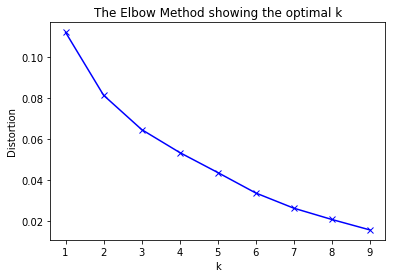

In [252]:
Venues_grouped_clusters = Venues_relative_freq.drop('City', 1)


# k means determine k
distortions = []
K = range(1,10)
for k in K:
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Venues_grouped_clusters)
    distortions.append(sum(np.min(cdist(Venues_grouped_clusters, kmeans.cluster_centers_, 'euclidean'), axis=1)) / Venues_grouped_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



The chart above shows a sharp decrease in the cost function when k increases from 1 to 2. In the next steps, the cost function decreases only slightly between every step. Most notably, from 3 to 4 the decrease in the loss function is almost constant as from 4 to 5. This indicates us that with k=3, we have a good balance between number of clusters and the information.

Next up is to run the K-means algorithm again with our chosen number of clusters (k=3).

In [253]:
# run k-means clustering with k = 3
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Venues_grouped_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0])

Now, let's make a table of our cities and the top 10 venues in those cities, determined by relative frequency per 1,000 inhabitants. We add a column showing the cluster the algorithm designated the city to.

In [254]:
# add clustering labels
neighborhoods_venues_sorted
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Venues_merged = cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Venues_merged = Venues_merged.join(neighborhoods_venues_sorted.set_index('City'), on='City')

Venues_merged.head(14) # check the last columns!

,City,Inhabitants,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Groningen,"231,618",53.221792,6.558245,0,Restaurant,Bar,Coffee Shop,Café,Theater,...,Concert Hall,Thai Restaurant,Park,Deli / Bodega,French Restaurant,Pizza Place,Plaza,Nightclub,Pet Café,Movie Theater
1,Leeuwarden,"92,235",53.199685,5.800691,0,Supermarket,Coffee Shop,Hotel,Bar,Diner,...,Museum,Nightclub,Pizza Place,Japanese Restaurant,Food,Burger Joint,Cuban Restaurant,Pub,Monument / Landmark,Pool Hall
2,Assen,"67,970",52.990372,6.553378,0,Supermarket,Hotel,Bar,Restaurant,Sandwich Place,...,Diner,Ice Cream Shop,Gym,Racetrack,Resort,Juice Bar,Electronics Store,Drugstore,Buffet,Flower Shop
3,Zwolle,"127,492",52.514565,6.097720,0,Bar,Restaurant,Park,Asian Restaurant,Supermarket,...,Clothing Store,Theater,Ice Cream Shop,Modern European Restaurant,Department Store,Gym / Fitness Center,Italian Restaurant,Lake,Indie Movie Theater,Lounge
4,Lelystad,"77,872",52.515095,5.476891,0,Clothing Store,Supermarket,Restaurant,Fast Food Restaurant,Boutique,...,Pool,Fried Chicken Joint,French Restaurant,Bowling Alley,Scenic Lookout,Pizza Place,Canal Lock,Kitchen Supply Store,History Museum,Chocolate Shop
5,Arnhem,"159,277",52.005664,5.876235,2,Coffee Shop,Restaurant,Café,Bar,Hotel,...,Mediterranean Restaurant,Diner,Exhibit,Burger Joint,Italian Restaurant,Ice Cream Shop,Creperie,Gym,History Museum,Japanese Restaurant
6,Utrecht,"352,795",52.080986,5.127684,0,Bar,Coffee Shop,Restaurant,Burger Joint,Bakery,...,Italian Restaurant,French Restaurant,Museum,Concert Hall,Café,Beer Bar,Gym / Fitness Center,Art Museum,Wine Bar,Bagel Shop
7,Haarlem,"161,213",52.383706,4.643560,0,Restaurant,Bar,Snack Place,Coffee Shop,Seafood Restaurant,...,Sushi Restaurant,Bistro,Furniture / Home Store,Theater,Thai Restaurant,Gastropub,Grocery Store,Plaza,Multiplex,Record Shop
8,Den Haag,"537,988",52.074946,4.269680,2,Restaurant,Coffee Shop,Bar,Park,Hotel,...,Thai Restaurant,French Restaurant,Italian Restaurant,Breakfast Spot,Beach,Indonesian Restaurant,Theater,Electronics Store,Gym / Fitness Center,Art Museum
9,Middelburg,"41,640",51.505295,3.610071,0,Restaurant,Café,Supermarket,Bar,Hotel,...,Soccer Field,Garden Center,Nightclub,French Restaurant,Liquor Store,History Museum,Buffet,Beer Garden,Pool,Fast Food Restaurant


### Map

Next, we will plot all cities on the map and indicate the different clusters using coloured markers.

In [255]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Venues_merged['Latitude'], Venues_merged['Longitude'], Venues_merged['City'], Venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [256]:
Cluster_one = Venues_merged[Venues_merged['Cluster Labels']==0]['City']
Cluster_two = Venues_merged[Venues_merged['Cluster Labels']==1]['City']
Cluster_three = Venues_merged[Venues_merged['Cluster Labels']==2]['City']

## Conclusion <a name="conclusion"></a>

This analysis compared the capital cities of the provinces in the Netherland (and Rotterdam and Amsterdam included as well). Using K-means clustering, the optimal number of clusters was found to find similarities within the number of venues per 1,000 inhabitants within the Netherlands. As can be seen from the map, there is one big cluster with similar cities. This cluster consists of the following cities:

In [257]:
Cluster_one

0            Groningen
1           Leeuwarden
2                Assen
3               Zwolle
4             Lelystad
6              Utrecht
7              Haarlem
9           Middelburg
10    's-Hertogenbosch
12           Amsterdam
13           Rotterdam
Name: City, dtype: object

Next, there is a much smaller cluster with only the following cities:

In [258]:
Cluster_three

5      Arnhem
8    Den Haag
Name: City, dtype: object

Finally, a cluster of just one city remains:

In [259]:
Cluster_two

11    Maastricht
Name: City, dtype: object

Interestingly, this last cluster is very different from the other clusters. As can be observed by the common venues, hotels and coffeeshop are very frequent for a city with a relatively low number of inhabitants. This may be explained by tourism.

In [268]:
Venues_merged.iloc[11]

City                              Maastricht
Inhabitants                          121,623
Latitude                              50.858
Longitude                            5.69699
Cluster Labels                             1
1st Most Common Venue            Coffee Shop
2nd Most Common Venue                  Hotel
3rd Most Common Venue                    Bar
4th Most Common Venue     Italian Restaurant
5th Most Common Venue                   Café
6th Most Common Venue              Gastropub
7th Most Common Venue         Clothing Store
8th Most Common Venue      French Restaurant
9th Most Common Venue             Restaurant
10th Most Common Venue                   Pub
11th Most Common Venue                 Plaza
12th Most Common Venue        Ice Cream Shop
13th Most Common Venue                  Park
14th Most Common Venue                Bistro
15th Most Common Venue      Sushi Restaurant
16th Most Common Venue      Tapas Restaurant
17th Most Common Venue       Thai Restaurant
18th Most 